# AdaBoost

Este notebook explora el problema de clasificación de las personas en vacunadas y no vacunadas usando el algoritmo Adaboost, que se emplea para mejorar iterativamente un algoritmo básico débil, enfocándose en los errores de la iteración previa. Si no se especifica el parámetro base_estimator, se utiliza DecisionTreeClassifier por defecto. Como en el caso de AdaBoost es interesante tener varios clasificadores débiles, se probará también como clasificador débil la regresión logística.

 Se cargan los datos y se construye la función para obtener rápidamente las métricas deseadas.

In [5]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import graphviz
import joblib
import optuna

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_train = pd.read_csv("../Data/Prueba_Jaime/preprocessed_train_dataset.csv", index_col="respondent_id")
X_test = pd.read_csv("../Data/Prueba_Jaime/preprocessed_test_dataset.csv", index_col="respondent_id")
y_train = pd.read_csv("../Data/Prueba_Jaime/labels_train_dataset.csv", index_col="respondent_id")
y_test =  pd.read_csv("../Data/Prueba_Jaime/labels_test_dataset.csv", index_col="respondent_id")

In [3]:
def evaluate_model(best_model, X_train, y_train):
    y_pred_proba = best_model.predict_proba(X_train)
    y_pred = best_model.predict(X_train)
    
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train)

    # Calcular ROC AUC para cada label
    roc_auc_scores = [
        roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
    ]

    # Calcular Accuracy para cada label
    accuracy_scores = [
        accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
    ]

    print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
    print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1], "\n")

    print(f"ROC AUC global: {roc_auc_score(y_train, y_pred)}")
    print("Accuracy global:", accuracy_score(y_train, y_pred))
    print("ROC AUC Scores de cada label:", roc_auc_scores)
    print("Accuracy Scores de cada label:", accuracy_scores, "\n")
    print("Reporte de Clasificación:")
    print(classification_report(y_train, y_pred, zero_division=0))
    
    return "-----------------------------------------------------------------------------------"


# 1.  Árbol de clasificación 

Adaboost se suele utilizar con árboles de decisión, ya que su forma de aprendizaje es simple y rápida, siendo ideal para optimizaciones rápidas e iterativas. Para los árboles de decisión no hace falta usar ningún tipo más de transformación de los datos, ya que no se basan en distancias y no tienen problemas de convergencia en datasets grandes. Su funcionamiento se basa en particionar el espacio de características a través de condiciones lógicas.

# Optimización con Bayes Search

Se emplea de nuevo la búsqueda en el espacio continuo, usando BayesSearch con el algoritmo SAMME y balanceado las clases, mientras que las métricas se calculan en base a la validación cruzada. Primero, se desea optimizar tanto a las características del propio modelo de árbol de decisión, como a las de Adaboost. Por tanto, la búsqueda se va a enfocar en los siguientes parámetros:
* max_depth: toma un valor entero dentro del intervalo [1, 10], estableciendo la profundidad del arbol
* min_samples_split: toma un valor entero dentro del rango [2, 20]. Este parámetro especifica el número mínimo de muestras necesarias para dividir un nodo interno en el árbol de decisión.
* min_samples_leaf: toma un valor entero dentro del rango [1, 10]. Este parámetro define el número mínimo de muestras que debe contener un nodo hoja.

Los parametros de Adaboost son: 
* n_estimators: Toma un valor entero dentro del rango [50, 300] y especifica cuántas veces se entrenará el modelo en el proceso iterativo de AdaBoost.
* learning_rate: Toma un valor real dentro del rango [0.01, 1.0], con una distribución logarítmica y determina el peso que tienen los estimadores débiles en cada iteración del proceso de AdaBoost.

In [25]:

# Crear el modelo base con class_weight='balanced'
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced'),  
    random_state=42
)

# Envolverlo en MultiOutputClassifier para predicción multietiqueta
multi_ada = MultiOutputClassifier(ada_model)

# Espacio de búsqueda de hiperparámetros
search_space = {
    'estimator__n_estimators': Integer(50, 300),  
    'estimator__learning_rate': Real(0.01, 1.0, prior='log-uniform'), 
    'estimator__estimator__max_depth': Integer(1, 10), 
    'estimator__estimator__min_samples_split': Integer(2, 20), 
    'estimator__estimator__min_samples_leaf': Integer(1, 10), 
    'estimator__algorithm': ['SAMME'], 
}

# Configurar BayesSearchCV
opt = BayesSearchCV(
    multi_ada,
    search_space,
    cv=5,
    n_iter=100,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
opt.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", opt.best_params_)

Mejores hiperparámetros: OrderedDict([('estimator__algorithm', 'SAMME'), ('estimator__estimator__max_depth', 7), ('estimator__estimator__min_samples_leaf', 1), ('estimator__estimator__min_samples_split', 2), ('estimator__learning_rate', 0.048665356824415335), ('estimator__n_estimators', 300)])


In [40]:
# Guardar el mejor modelo optimizado
joblib.dump(opt.best_estimator_, "../Modelos/Prueba_Jaime/Adaboost_arbol_bayes_balanced.pkl")
print("Modelo guardado como 'Adaboost_arbol_bayes_balanced.pkl'")


Modelo guardado como 'Adaboost_arbol_bayes_balanced.pkl'


In [41]:

# Guardar resultados
results = pd.DataFrame(opt.cv_results_)
columns = [
    'mean_test_score',  
    'param_estimator__n_estimators',  
    'param_estimator__learning_rate', 
    'param_estimator__estimator__max_depth',
    'param_estimator__estimator__min_samples_split',
    'param_estimator__estimator__min_samples_leaf',
    'param_estimator__algorithm',  
]
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/AdaBoost_arbol_bayes_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_score'], ascending=False).head(5)


,mean_test_score,param_estimator__n_estimators,param_estimator__learning_rate,param_estimator__estimator__max_depth,param_estimator__estimator__min_samples_split,param_estimator__estimator__min_samples_leaf,param_estimator__algorithm
45,0.860491,300,0.048665,7,2,1,SAMME
56,0.860374,258,0.048111,7,20,1,SAMME
29,0.860316,183,0.082854,6,2,1,SAMME
76,0.860288,254,0.033084,7,2,10,SAMME
69,0.860197,300,0.055334,7,20,5,SAMME


El modelo resulta en un ROC_AUC medio de alrededor del 86% en el caso de los mejores modelos. Se puede observar que BayesSearch indica como mejores aquellos modelos con más estimadores débiles y una tasa de aprendizaje pequeña. El mejor modelo tiene los siguientes parámetros: 'estimator__estimator__max_depth' = 7, 'estimator__estimator__min_samples_leaf' = 1, 'estimator__estimator__min_samples_split' = 2, 'estimator__learning_rate' = 0.048665356824415335, 'estimator__n_estimators' = 300.

En cuanto a las métricas, el ROC AUC global es de 0.8096, lo que indica un buen rendimiento general del modelo en cuanto a la capacidad de distinguir entre las clases. El Accuracy global es de 0.6809,lo que significa que el modelo acierta aproximadamente el 68% de las veces las dos etiquetas juntas. Es más difícil acertar ambas etiquetas a la vez que por separado.

Por otro lado, los ROC AUC Scores para cada etiqueta son 0.8941 y 0.8949, reflejando un desempeño bueno en cada clase individualmente. El accuracy por etiqueta es 0.8162, respectivamente 0.8105. 

In [42]:
# Evaluacion en train
best_model = joblib.load("../Modelos/Prueba_Jaime/AdaBoost_arbol_bayes_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.31715602 0.58909604 0.11920292 0.12419606 0.1617338 ]
Primeras 5 probabilities para label 1: [0.70579074 0.73027018 0.68007838 0.16159721 0.44237299] 

ROC AUC global: 0.8096501654180419
Accuracy global: 0.6808910747866339
ROC AUC Scores de cada label: [0.8940996104033259, 0.8948760219199482]
Accuracy Scores de cada label: [0.8161917160904576, 0.8104537345098607] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.55      0.80      0.65      4433
           1       0.79      0.81      0.80      9718

   micro avg       0.70      0.80      0.75     14151
   macro avg       0.67      0.80      0.72     14151
weighted avg       0.72      0.80      0.75     14151
 samples avg       0.38      0.40      0.38     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.11920292 0.79423291 0.16328854 0.68200747 0.

# Optimización con Optuna

Igualmente, Optuna se usa para la búsqueda de los mejores parametros, aplicando balanceo y validación cruzada con 5 folds durante 20 trials. La mejor es la prueba 12 con valor medio de ROC_AUC: 0.8605416140558757.

In [4]:

def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    max_depth = trial.suggest_int('max_depth', 1, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    algorithm = trial.suggest_categorical('algorithm', ['SAMME'])

    # Crear el modelo base con DecisionTreeClassifier
    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
    )

    # Crear el modelo de AdaBoostClassifier
    ada_model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=42
    )

    # Envolver el modelo en MultiOutputClassifier para predicción multietiqueta
    multi_ada = MultiOutputClassifier(ada_model)

    # Realizar la validación cruzada para calcular el ROC AUC
    roc_auc_scores = cross_val_score(
        multi_ada, X_train, y_train, cv=5, scoring='roc_auc'
    )

    # Promediar los ROC AUC obtenidos durante la validación cruzada
    score = roc_auc_scores.mean()

    return score

# Crear un estudio de optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  


[I 2025-01-23 21:25:02,773] A new study created in memory with name: no-name-5517642f-bc6b-4493-b73f-584999696da9
[I 2025-01-23 21:25:13,340] Trial 0 finished with value: 0.8403564214219383 and parameters: {'max_depth': 3, 'n_estimators': 131, 'learning_rate': 0.39483411151276104, 'min_samples_split': 18, 'min_samples_leaf': 3, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.8403564214219383.
[I 2025-01-23 21:25:46,354] Trial 1 finished with value: 0.8509406120710263 and parameters: {'max_depth': 4, 'n_estimators': 235, 'learning_rate': 0.3099164357826222, 'min_samples_split': 4, 'min_samples_leaf': 9, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.8509406120710263.
[I 2025-01-23 21:25:53,514] Trial 2 finished with value: 0.8473674458919623 and parameters: {'max_depth': 4, 'n_estimators': 194, 'learning_rate': 0.6723001333877334, 'min_samples_split': 5, 'min_samples_leaf': 1, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.8509406120710263.
[I 2025-01-23 21:26:37,046] T

In [5]:

# Entrenar el mejor modelo con los parámetros encontrados
best_params = study.best_params
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf']
    ),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    algorithm=best_params['algorithm'],
    random_state=42
)
multi_best_model = MultiOutputClassifier(best_model)

# Ajustar el mejor modelo con los datos de entrenamiento
multi_best_model.fit(X_train, y_train)

# Guardar el mejor modelo
joblib.dump(multi_best_model, "../Modelos/Prueba_Jaime/AdaBoost_arbol_optuna.pkl")
print("Mejor modelo guardado como 'AdaBoost_arbol_optuna.pkl'")

Mejor modelo guardado como 'AdaBoost_arbol_optuna.pkl'


In [6]:
print("Mejores parámetros encontrados:", study.best_params)

# Guardar resultados
trials_df = study.trials_dataframe()

columns = [
    'value',  
    'params_learning_rate',  
    'params_n_estimators', 
    'params_max_depth',
    'params_min_samples_leaf',
    'params_min_samples_split',
    'params_max_depth', 
    'params.algorithm'  
]

trials_df = trials_df[trials_df.columns.intersection(columns)]
trials_df.sort_values(by='value', ascending=False, inplace=True)

results_csv_path = '../Results/Prueba_Jaime/AdaBoost_arbol_optuna_results_table.csv'
trials_df.to_csv(results_csv_path, index=False)
trials_df.head(5)

Mejores parámetros encontrados: {'max_depth': 6, 'n_estimators': 93, 'learning_rate': 0.08079858285560716, 'min_samples_split': 14, 'min_samples_leaf': 7, 'algorithm': 'SAMME'}


,value,params_learning_rate,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators
12,0.860542,0.080799,6,7,14,93
18,0.860136,0.126194,6,5,16,143
13,0.860109,0.124967,6,6,15,100
15,0.858972,0.133208,6,10,9,94
3,0.858370,0.080010,7,6,19,63


Los mejores parámetros encontrados son: **'max_depth' = 6**, **'n_estimators' = 93**, **'learning_rate' = 0.0808**, **'min_samples_split' = 14**, **'min_samples_leaf' = 7**, y **'algorithm' = 'SAMME'**. El modelo entrenado presenta un ROC AUC global de 0.7708, lo que indica un buen desempeño en la clasificación. Para cada etiqueta los ROC AUC Scores son altos (0.8943 y 0.8808). El Accuracy global es de 0.709, mientras que los Accuracy Scores por etiqueta son también altos (0.8673 y 0.7991).

Aun así, el recall es bajo (0.53), lo que significa que solo el 53% de las instancias reales de la clase 1 del label 0 fueron identificadas correctamente. 

In [7]:
# Evaluacion en train
best_model = joblib.load("../Modelos/Prueba_Jaime/AdaBoost_arbol_optuna.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.24804402 0.32112448 0.11920292 0.15403545 0.16483429]
Primeras 5 probabilities para label 1: [0.7188789  0.70695894 0.70244926 0.14949528 0.43340767] 

ROC AUC global: 0.7708448931722536
Accuracy global: 0.7089541443656878
ROC AUC Scores de cada label: [0.8942557988021167, 0.8807915612991188]
Accuracy Scores de cada label: [0.8673031486571194, 0.7991224263464969] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.53      0.63      4433
           1       0.79      0.78      0.78      9718

   micro avg       0.79      0.70      0.74     14151
   macro avg       0.79      0.65      0.71     14151
weighted avg       0.79      0.70      0.74     14151
 samples avg       0.37      0.35      0.35     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.11920292 0.51775846 0.15904989 0.26082145 0.

# 2. Regresión Logistica

Ya hemos visto que la regresión logística converge más rápido usando datos escalados, mientras que los resultados siguen siendo casi iguales con respecto a las métricas de evaluación. Por esta razón, se empleará la normalización de nuevo con la meta de apresurar el proceso, ya que al añadir la complejidad inherente de Adaboost se hace mucho  más costoso y dura más. 

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[0.25      , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.66666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.25      , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 0.66666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.33333333, 0.        , ..., 0.        , 1.        ,
        0.        ]])

# Optimizacion con Grid Search

De los intentos previos utilizando regresión logística, hemos identificado que un buen candidato para el modelo es aquel que tiene los siguientes parámetros: 'C' = 0.27417237838541564, 'penalty' = 'l2', y 'solver' = 'liblinear'. Estos parámetros fueron obtenidos a través de un proceso de búsqueda utilizando Optuna, lo que nos permitió explorar de manera eficiente el espacio de hiperparámetros y encontrar una combinación óptima. Sin embargo, surge la pregunta de si es posible mejorar aún más este modelo.

Con esta meta se va a aplicar primero un GridSearch con  'estimator__n_estimators': [5, 10, 20, 30, 50] y 'estimator__learning_rate': [0.01, 0.1, 1,  10, 100].

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the best parameters (as per your grid search results for Logistic Regression)
best_params = {
    'penalty': 'l2',
    'solver': 'liblinear',
    'max_iter': 5000,
    'C': 0.27417237838541564
}

base_estimator = LogisticRegression(**best_params)
adaboost = AdaBoostClassifier(
    base_estimator,  
    n_estimators=100,  
    learning_rate=2.0, 
    algorithm='SAMME.R',  
    random_state=42
)
adaboost_multioutput = MultiOutputClassifier(adaboost)


param_grid = {
    'estimator__n_estimators': [5, 10, 20, 30, 50],  
    'estimator__learning_rate': [0.01, 0.1, 1,  10, 100], 
    'estimator__algorithm': ['SAMME'] 
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=adaboost_multioutput,
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,  
    verbose=1,  
    scoring='roc_auc', 
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and model from grid search
print("Best Parameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters:  {'estimator__algorithm': 'SAMME', 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 50}


In [40]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, "../Modelos/Prueba_Jaime/Adaboost_LogisitcRegression_gridsearch_balanced.pkl")
print("Modelo guardado como 'Adaboost_LogisitcRegression_gridsearch_balanced.pkl'")


Modelo guardado como 'Adaboost_LogisitcRegression_gridsearch_balanced.pkl'


El nuevo modelo Adaboost usa estimator__learning_rate': 0.1 y 'estimator__n_estimators': 50 para obtener un ROC_AUC medio con un valor alto. Las etiquetas tienen por separado ROC_AUCS en valor de 0.8389875516601084 y 0.8417806048543709, mientras que las métricas accuracy presentan valores de 0.819808091036212 y 0.7618014369063117.

Este modelo no funciona igual de bien que el modelo basado en árboles de clasificación.

In [33]:
best_model = joblib.load("../Modelos/Prueba_Jaime/Adaboost_LogisitcRegression_gridsearch_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train_scaled, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test_scaled, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.14104445 0.58184653 0.12324547 0.12324547 0.12931942]
Primeras 5 probabilities para label 1: [0.82421133 0.76365855 0.8327841  0.12585614 0.59882741] 

ROC AUC global: 0.7604452172781144
Accuracy global: 0.6508992719031775
ROC AUC Scores de cada label: [0.8389875516601084, 0.8417806048543709]
Accuracy Scores de cada label: [0.819808091036212, 0.7618014369063117] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      4433
           1       0.75      0.74      0.74      9718

   micro avg       0.69      0.71      0.70     14151
   macro avg       0.66      0.70      0.68     14151
weighted avg       0.69      0.71      0.70     14151
 samples avg       0.34      0.35      0.34     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.11920292 0.49027273 0.12324547 0.12324547 0.1

# Mejor modelo - Evaluación en test 

Medidas de evaluación-----------------------------------------------
ROC AUC Scores del mejor modelo: [0.8738890385133314, 0.8637764829326011]
Accuracy Scores del mejor modelo: [0.8569778633301252, 0.7878729547641964] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.74      0.51      0.60      1106
           1       0.78      0.77      0.77      2430

   micro avg       0.77      0.69      0.72      3536
   macro avg       0.76      0.64      0.69      3536
weighted avg       0.76      0.69      0.72      3536
 samples avg       0.36      0.34      0.34      3536

Probabilidades-----------------------------------------------------
Primeras 5 probabilities para label 0: [0.11920292 0.51775846 0.15904989 0.26082145 0.22779857]
Primeras 5 probabilities para label 1: [0.34380311 0.72314706 0.13845893 0.2996505  0.22363687]


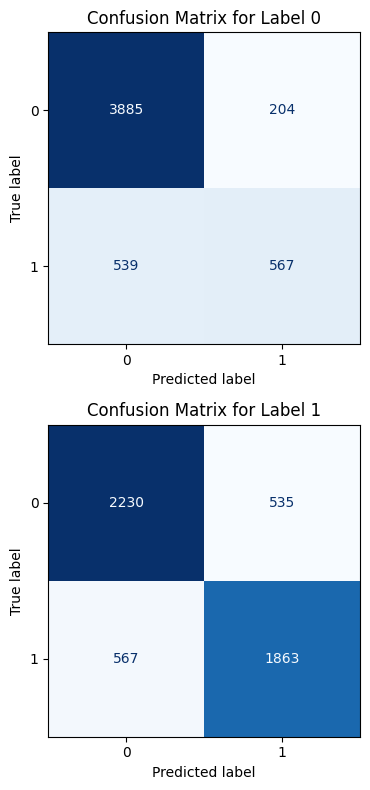

In [7]:
# Evaluacion en test
best_model = joblib.load("../Modelos/Prueba_Jaime/AdaBoost_arbol_optuna.pkl")
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Calcular ROC AUC para cada label
roc_auc_scores = [
    roc_auc_score(y_test.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_test.shape[1])
]

# Calcular Accuracy para cada label
accuracy_scores = [
    accuracy_score(y_test.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_test.shape[1])
]

print("Medidas de evaluación-----------------------------------------------")
print("ROC AUC Scores del mejor modelo:", roc_auc_scores)
print("Accuracy Scores del mejor modelo:", accuracy_scores, "\n")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Probabilidades-----------------------------------------------------")
print("Primeras 5 probabilities para label 0:", y_pred_proba[0][:5, 1])
print("Primeras 5 probabilities para label 1:", y_pred_proba[1][:5, 1])

# Matriz de confusion
y_pred = best_model.predict(X_test)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=100)  # 2 rows, 1 column
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion Matrix for Label {i}')
plt.tight_layout()
plt.show()


# Gráfico final

In [11]:
# Load the best model
best_model = joblib.load("../Modelos/Prueba_Jaime/AdaBoost_arbol_optuna.pkl")

# Predictions and probabilities for test set
y_pred_proba_test = best_model.predict_proba(X_test)
y_pred_proba_train = best_model.predict_proba(X_train)
y_pred_proba_test

[array([[0.88079708, 0.11920292],
        [0.48224154, 0.51775846],
        [0.84095011, 0.15904989],
        ...,
        [0.87276482, 0.12723518],
        [0.55378734, 0.44621266],
        [0.65527978, 0.34472022]]),
 array([[0.65619689, 0.34380311],
        [0.27685294, 0.72314706],
        [0.86154107, 0.13845893],
        ...,
        [0.77816876, 0.22183124],
        [0.34079048, 0.65920952],
        [0.57995739, 0.42004261]])]

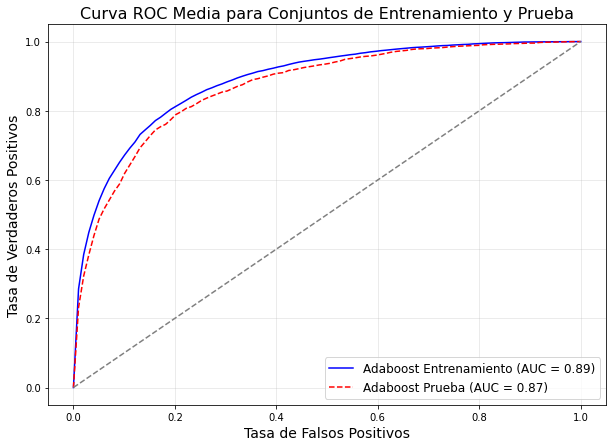

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convertir las predicciones a arrays de NumPy si son listas
y_pred_proba_train = np.array(y_pred_proba_train)  # Forma: (n_clases, n_muestras, 2)
y_pred_proba_test = np.array(y_pred_proba_test)

# Asegurarse de que y_train y y_test sean arrays de NumPy (codificación one-hot)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Inicializar variables
n_labels = y_pred_proba_train.shape[0]  # Número de etiquetas
mean_fpr = np.linspace(0, 1, 100)  # Puntos de FPR para interpolación
train_tprs, test_tprs = [], []  # Listas para almacenar TPRs
train_aucs, test_aucs = [], []  # Listas para almacenar AUCs

plt.figure(figsize=(10, 7))  # Tamaño de la figura

# Bucle a través de cada etiqueta para calcular las curvas ROC y AUCs
for i in range(n_labels):
    # Extraer las probabilidades para la clase positiva
    y_prob_train = y_pred_proba_train[i, :, 1]
    y_prob_test = y_pred_proba_test[i, :, 1]

    # Calcular la curva ROC y AUC para el conjunto de entrenamiento
    fpr_train, tpr_train, _ = roc_curve(y_train[:, i], y_prob_train)
    train_tprs.append(np.interp(mean_fpr, fpr_train, tpr_train))  # Interpolar TPR
    train_tprs[-1][0] = 0.0  # Asegurarse de que TPR empiece en 0
    train_aucs.append(auc(fpr_train, tpr_train))  # Calcular AUC

    # Calcular la curva ROC y AUC para el conjunto de prueba
    fpr_test, tpr_test, _ = roc_curve(y_test[:, i], y_prob_test)
    test_tprs.append(np.interp(mean_fpr, fpr_test, tpr_test))  # Interpolar TPR
    test_tprs[-1][0] = 0.0  # Asegurarse de que TPR empiece en 0
    test_aucs.append(auc(fpr_test, tpr_test))  # Calcular AUC

# Calcular la media de TPRs y AUCs para las curvas ROC
mean_train_tpr = np.mean(train_tprs, axis=0)
mean_test_tpr = np.mean(test_tprs, axis=0)
mean_train_auc = np.mean(train_aucs)
mean_test_auc = np.mean(test_aucs)

# Graficar las curvas ROC
plt.plot(mean_fpr, mean_train_tpr, label=f"Adaboost Entrenamiento (AUC = {mean_train_auc:.2f})", color='blue')
plt.plot(mean_fpr, mean_test_tpr, label=f"Adaboost Prueba (AUC = {mean_test_auc:.2f})", color='red', linestyle='--')

# Formato de la gráfica
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.title("Curva ROC Media para Conjuntos de Entrenamiento y Prueba", fontsize=16)
plt.xlabel("Tasa de Falsos Positivos", fontsize=14)
plt.ylabel("Tasa de Verdaderos Positivos", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()



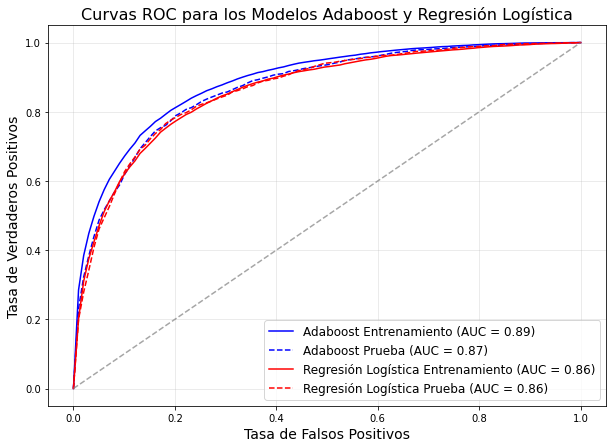

In [19]:

# Convertir las predicciones a arrays de NumPy
basic_pred_proba_train = np.array(basic_pred_proba_train)  # Forma: (n_clases, n_muestras, 2)
basic_pred_proba_test = np.array(basic_pred_proba_test)

# Inicializar listas para almacenar los datos de la curva ROC
basic_train_tprs, basic_test_tprs = [], []  # TPRs para entrenamiento y prueba
basic_train_aucs, basic_test_aucs = [], []  # AUCs para entrenamiento y prueba

# Bucle a través de cada etiqueta para el modelo básico
for i in range(y_train.shape[1]):
    # Extraer las probabilidades para la clase positiva
    y_prob_basic_train = basic_pred_proba_train[i, :, 1]
    y_prob_basic_test = basic_pred_proba_test[i, :, 1]

    # Calcular la curva ROC y AUC para el modelo básico en el conjunto de entrenamiento
    fpr_train, tpr_train, _ = roc_curve(y_train[:, i], y_prob_basic_train)
    basic_train_tprs.append(np.interp(mean_fpr, fpr_train, tpr_train))  # Interpolación de TPR
    basic_train_tprs[-1][0] = 0.0  # Asegurarse de que TPR comience en 0
    basic_train_aucs.append(auc(fpr_train, tpr_train))  # Calcular AUC

    # Calcular la curva ROC y AUC para el modelo básico en el conjunto de prueba
    fpr_test, tpr_test, _ = roc_curve(y_test[:, i], y_prob_basic_test)
    basic_test_tprs.append(np.interp(mean_fpr, fpr_test, tpr_test))  # Interpolación de TPR
    basic_test_tprs[-1][0] = 0.0  # Asegurarse de que TPR comience en 0
    basic_test_aucs.append(auc(fpr_test, tpr_test))  # Calcular AUC

# Calcular la media y desviación estándar para las curvas ROC del modelo básico
mean_basic_train_tpr = np.mean(basic_train_tprs, axis=0)  # Promedio de TPRs para entrenamiento
mean_basic_test_tpr = np.mean(basic_test_tprs, axis=0)  # Promedio de TPRs para prueba
mean_basic_train_auc = np.mean(basic_train_aucs)  # Promedio de AUCs para entrenamiento
mean_basic_test_auc = np.mean(basic_test_aucs)  # Promedio de AUCs para prueba

# Añadir las curvas al gráfico existente
plt.figure(figsize=(10, 7))

# Curvas de Adaboost (código previo)
plt.plot(mean_fpr, mean_train_tpr, label=f"Adaboost Entrenamiento (AUC = {mean_train_auc:.2f})", color='blue')
plt.plot(mean_fpr, mean_test_tpr, label=f"Adaboost Prueba (AUC = {mean_test_auc:.2f})", color='blue', linestyle='--')

# Curvas de Regresión Logística (Modelo Básico)
plt.plot(mean_fpr, mean_basic_train_tpr, label=f"Regresión Logística Entrenamiento (AUC = {mean_basic_train_auc:.2f})", color='red')
plt.plot(mean_fpr, mean_basic_test_tpr, label=f"Regresión Logística Prueba (AUC = {mean_basic_test_auc:.2f})", color='red', linestyle='--')

# Formato del gráfico
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7)  # Línea diagonal
plt.title("Curvas ROC para los Modelos Adaboost y Regresión Logística", fontsize=16)
plt.xlabel("Tasa de Falsos Positivos", fontsize=14)
plt.ylabel("Tasa de Verdaderos Positivos", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


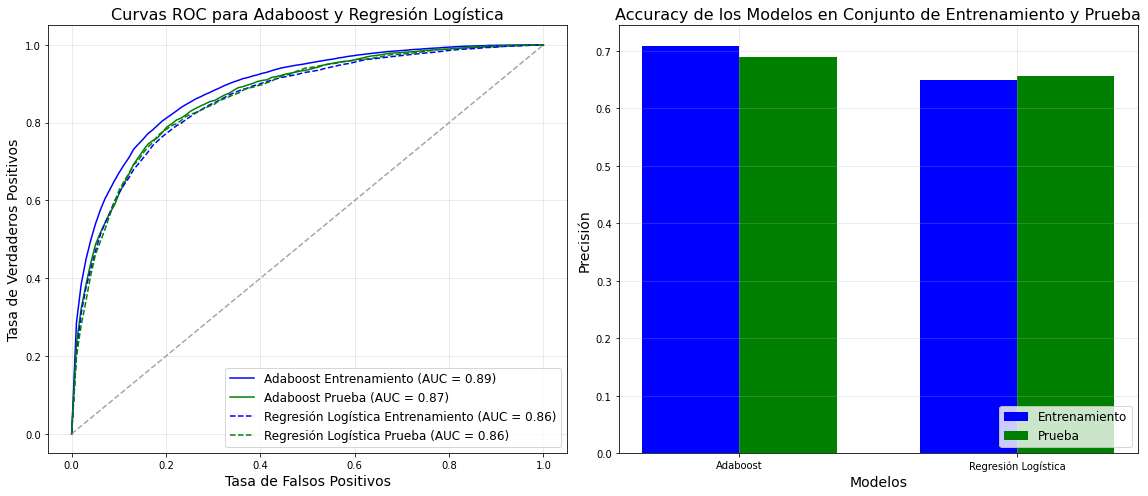

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Calcular las predicciones del modelo básico y Adaboost
y_pred_basic_train = basic_model.predict(X_train)
y_pred_basic_test = basic_model.predict(X_test)
y_pred_ada_train = best_model.predict(X_train)
y_pred_ada_test = best_model.predict(X_test)

# Calcular la precisión (accuracy) para ambos modelos en entrenamiento y prueba
accuracy_basic_train = accuracy_score(y_train, y_pred_basic_train)
accuracy_basic_test = accuracy_score(y_test, y_pred_basic_test)
accuracy_ada_train = accuracy_score(y_train, y_pred_ada_train)
accuracy_ada_test = accuracy_score(y_test, y_pred_ada_test)

# Crear las curvas ROC (como antes)
# Convertir las probabilidades de las predicciones a arrays de NumPy
basic_pred_proba_train = np.array(basic_pred_proba_train)  
basic_pred_proba_test = np.array(basic_pred_proba_test)

# Inicializar listas para almacenar los datos de la curva ROC
basic_train_tprs, basic_test_tprs = [], []
basic_train_aucs, basic_test_aucs = [], []

# Bucle a través de cada etiqueta para el modelo básico
for i in range(y_train.shape[1]):
    # Extraer las probabilidades para la clase positiva
    y_prob_basic_train = basic_pred_proba_train[i, :, 1]
    y_prob_basic_test = basic_pred_proba_test[i, :, 1]

    # Calcular la curva ROC y AUC para el modelo básico en el conjunto de entrenamiento
    fpr_train, tpr_train, _ = roc_curve(y_train[:, i], y_prob_basic_train)
    basic_train_tprs.append(np.interp(mean_fpr, fpr_train, tpr_train))
    basic_train_tprs[-1][0] = 0.0
    basic_train_aucs.append(auc(fpr_train, tpr_train))

    # Calcular la curva ROC y AUC para el modelo básico en el conjunto de prueba
    fpr_test, tpr_test, _ = roc_curve(y_test[:, i], y_prob_basic_test)
    basic_test_tprs.append(np.interp(mean_fpr, fpr_test, tpr_test))
    basic_test_tprs[-1][0] = 0.0
    basic_test_aucs.append(auc(fpr_test, tpr_test))

# Calcular la media y desviación estándar para las curvas ROC del modelo básico
mean_basic_train_tpr = np.mean(basic_train_tprs, axis=0)
mean_basic_test_tpr = np.mean(basic_test_tprs, axis=0)
mean_basic_train_auc = np.mean(basic_train_aucs)
mean_basic_test_auc = np.mean(basic_test_aucs)

# Crear el gráfico con dos subgráficos: uno para las curvas ROC y otro para las precisiones
fig, ax = plt.subplots(1, 2, figsize=(16, 7))  # Un gráfico con dos columnas

# Colores consistentes: Azul, Verde, Rojo, Naranja
roc_colors = ['blue', 'green']

# Graficar las curvas ROC con colores consistentes
ax[0].plot(mean_fpr, mean_train_tpr, label=f"Adaboost Entrenamiento (AUC = {mean_train_auc:.2f})", color=roc_colors[0])
ax[0].plot(mean_fpr, mean_test_tpr, label=f"Adaboost Prueba (AUC = {mean_test_auc:.2f})", color=roc_colors[1])
ax[0].plot(mean_fpr, mean_basic_train_tpr, label=f"Regresión Logística Entrenamiento (AUC = {mean_basic_train_auc:.2f})", color=roc_colors[0], linestyle='--')
ax[0].plot(mean_fpr, mean_basic_test_tpr, label=f"Regresión Logística Prueba (AUC = {mean_basic_test_auc:.2f})", color=roc_colors[1], linestyle='--')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7)  # Línea diagonal
ax[0].set_title("Curvas ROC para Adaboost y Regresión Logística", fontsize=16)
ax[0].set_xlabel("Tasa de Falsos Positivos", fontsize=14)
ax[0].set_ylabel("Tasa de Verdaderos Positivos", fontsize=14)
ax[0].legend(loc="lower right", fontsize=12)
ax[0].grid(alpha=0.3)

# Graficar las precisiones con los mismos colores
models = ['Adaboost', 'Regresión Logística']
train_accuracies = [accuracy_ada_train, accuracy_basic_train]
test_accuracies = [accuracy_ada_test, accuracy_basic_test]

# Bar plot de precisión con colores consistentes
bar_width = 0.35
index = np.arange(len(models))

# Usamos los mismos colores para las barras que en las curvas ROC
bar1 = ax[1].bar(index, train_accuracies, bar_width, label='Entrenamiento', color=roc_colors[0])  # Azul
bar2 = ax[1].bar(index + bar_width, test_accuracies, bar_width, label='Prueba', color=roc_colors[1])  # Verde

# Asignar las etiquetas y el título al gráfico de barras
ax[1].set_xlabel('Modelos', fontsize=14)
ax[1].set_ylabel('Precisión', fontsize=14)
ax[1].set_title('Accuracy de los Modelos en Conjunto de Entrenamiento y Prueba', fontsize=16)
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(models)
ax[1].legend(loc="lower right", fontsize=12)
ax[1].grid(alpha=0.3)

# Ajustar el layout para que se vea bien
plt.tight_layout()  
plt.show()




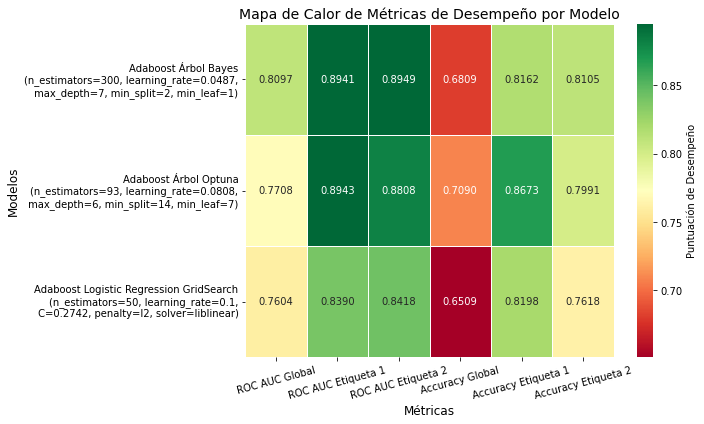

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Datos
modelos = [
    'Adaboost Árbol Bayes\n(n_estimators=300, learning_rate=0.0487,\n max_depth=7, min_split=2, min_leaf=1)', 
    'Adaboost Árbol Optuna\n(n_estimators=93, learning_rate=0.0808,\n max_depth=6, min_split=14, min_leaf=7)', 
    'Adaboost Logistic Regression GridSearch\n(n_estimators=50, learning_rate=0.1,\n C=0.2742, penalty=l2, solver=liblinear)'
]

metricas = [
    'ROC AUC Global', 'ROC AUC Etiqueta 1', 'ROC AUC Etiqueta 2',
    'Accuracy Global', 'Accuracy Etiqueta 1', 'Accuracy Etiqueta 2'
]
datos = [
    [0.8097, 0.8941, 0.8949, 0.6809, 0.8162, 0.8105],
    [0.7708, 0.8943, 0.8808, 0.7090, 0.8673, 0.7991],
    [0.7604, 0.8390, 0.8418, 0.6509, 0.8198, 0.7618]
]

# Crear un DataFrame
df = pd.DataFrame(datos, index=modelos, columns=metricas)

# Graficar el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='RdYlGn', fmt=".4f", cbar=True, linewidths=0.5,
            cbar_kws={'label': 'Puntuación de Desempeño'})

# Títulos y etiquetas
plt.title('Mapa de Calor de Métricas de Desempeño por Modelo', fontsize=14)
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Modelos', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfico
plt.show()